In [196]:
# First import all dependencies
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
from torch.amp import autocast
from torch.cuda.amp import GradScaler

In [197]:
IMG_SIZE = 32 # Resize CIFAR-10 3*32*32
TRAIN_RATIO = 0.8
BATCH_SIZE= 256
IN_CHANNELS = 3
EMBED_DIM = 256
PATCH_SIZE = 4
NUM_HEADS = 8 # For multi attention layer
DEPTH = 10 # Number of tarnsformer layers
DROPOUT = 0.2
MPL_DIM = 256
NUM_CLASSES = 10 # Numbe of categories in CIFAR-10
TOTAL_EPOCHS = 400
WARM_UP_EPOCHS = 20


In [198]:
# Prepare the transformations to be done on each image
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

In [199]:
# Load the datasets
train_dataset = datasets.CIFAR10('/worshop/data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10('/workshop/data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [200]:
# Separate training data into train data and validation data
train_len = int(TRAIN_RATIO * len(train_dataset))
validation_len = len(train_dataset) - train_len
training_data, validation_data = random_split(train_dataset, [train_len, validation_len])

In [201]:
# Load the data
training_data_loader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=10, pin_memory=True, prefetch_factor=4, persistent_workers=True)
validation_data_loader = DataLoader(validation_data, batch_size=BATCH_SIZE, num_workers=10, pin_memory=True, prefetch_factor=4, persistent_workers=True)
test_data_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=10, pin_memory=True, prefetch_factor=4, persistent_workers=True)

In [202]:
### Model start ###
## First Patch Embedding ##
class PatchEmbedding(nn.Module):
  def __init__(self, in_channels=3, embed_dim=128, patch_size=4, img_size=224):
    super().__init__()
    self.proj = nn.Conv2d(in_channels=in_channels, out_channels=embed_dim, kernel_size=patch_size, stride=patch_size)
    self.patch_size = patch_size
    self.num_patches = (img_size//patch_size) ** 2

  def forward(self, x):
    x = self.proj(x) # B, embed_dim, H/P, W/P
    x = x.flatten(2) # B, embed_dim, N
    x = x.transpose(1,2) # B, N, embed_dim
    return x

class ViT(nn.Module):
  def __init__(self, in_channels, embed_dim, patch_size, img_size, num_heads, dropout, mlp_dim, depth, num_classes):
    super().__init__()
    self.patch = PatchEmbedding(in_channels=in_channels, embed_dim=embed_dim, patch_size=patch_size, img_size=img_size)
    num_patches = self.patch.num_patches
    self.dropout = nn.Dropout(dropout)
    self.cls = nn.Parameter(torch.zeros((1, 1, embed_dim)))
    self.positions = nn.Parameter(torch.ones(1, num_patches+1, embed_dim))

    encoding_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads,dim_feedforward=mlp_dim, dropout=dropout, batch_first=True)
    self.encoding_transformer = nn.TransformerEncoder(encoder_layer=encoding_layer, num_layers=depth)

    self.norm = nn.LayerNorm(embed_dim)
    self.head = nn.Linear(embed_dim, num_classes)

  def forward(self, x):
    x = self.patch(x)
    B = x.shape[0]
    cls = self.cls.expand(B, -1, -1)
    x = torch.cat((cls,x), dim=1)
    x = x + self.positions[:, :x.shape[1], :]
    x = self.encoding_transformer(x)
    x = self.norm(x)
    return self.dropout(self.head(x[:,0]))






In [203]:
#### Traning loop ###
def train(model, loader, optimizer, criterion, device, scaler):
  model.train()
  total_correct = 0
  total_loss = 0
  total = 0
  for images, label in loader:
    images = images.to(device, non_blocking=True)
    label = label.to(device, non_blocking=True)
    optimizer.zero_grad()

    with autocast(device_type="cuda" if torch.cuda.is_available() else "cpu"):
      output = model(images)
      loss = criterion(output, label)

    scaler.scale(loss).backward() # scale backward propagation
    scaler.step(optimizer)        # scaled optimizer step
    scaler.update()               # scale update for next iteration

    total_loss += loss.item() * images.size(0)
    total_correct += (output.argmax(dim=1)==label).sum().item()
    total += label.size(0)
  return total_loss/total, total_correct/total

In [204]:
## Validation loop ##

def validate(model, loader, criterion, device):
  model.eval()
  total_correct = 0
  total_loss = 0
  total = 0
  with torch.no_grad():
    for images, label in loader:
      images = images.to(device, non_blocking=True)
      label = label.to(device, non_blocking=True)

      with autocast(device_type="cuda" if torch.cuda.is_available() else "cpu"):
        output = model(images)
        loss = criterion(output, label)

      total_loss += loss.item() * images.size(0)
      total_correct += (output.argmax(dim=1)==label).sum().item()
      total += label.size(0)
  return total_loss/total, total_correct/total


In [205]:
def learning_rate_lambda(current_epoch):
    # Based upon SGDR: Stochastic Gradient Descent with Warm Restarts
    if current_epoch < WARM_UP_EPOCHS:
        # Linear warmup
        return float(current_epoch)/ float(WARM_UP_EPOCHS)
    else:
        # Cosine decay
        # The below ranges from 0 to ~1
        progress = (current_epoch - WARM_UP_EPOCHS)/(TOTAL_EPOCHS - WARM_UP_EPOCHS)

        # This one ranges from -1 to 1 through cos(); and then shift and scaled between 0 and 1
        return 0.5 * (1. + math.cos(math.pi * progress))
        

In [206]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViT(IN_CHANNELS, EMBED_DIM, PATCH_SIZE, IMG_SIZE, NUM_HEADS, DROPOUT, MPL_DIM, DEPTH, NUM_CLASSES)
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss(label_smoothing=0.01)
scaler = GradScaler()
epochs = 400
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, learning_rate_lambda)


In [207]:
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
params


3990282

In [208]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.min_delta = min_delta
        self.patience = patience
        self.early_stop = False
        self.best_value = None
        self.counter = 0
    def __call__(self, val):
        if self.best_value is None:
            self.best_value = val

        if val > self.best_value - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.counter = 0
            self.best_value = val

In [209]:
training_losses = []
training_accuracies = []
validation_losses = []
validation_accuracies = []
early_stopping = EarlyStopping(patience = 10, min_delta = 0.001)
for epoch in range(epochs):
  training_loss, training_accuracy = train(model, training_data_loader, optimizer, criterion, device, scaler)
  validation_loss, validation_accuracy = validate(model, validation_data_loader, criterion, device)
  training_losses.append(training_loss)
  training_accuracies.append(training_accuracy)
  validation_losses.append(validation_loss)
  validation_accuracies.append(validation_accuracy)
  print(f"Epoch: {epoch+1}/{epochs}")
  print(f"Training average loss: {training_loss}, accuracy: {training_accuracy}")
  print(f"Validation average loss: {validation_loss}, accuracy: {validation_accuracy}")
  scheduler.step()
  early_stopping(validation_loss)
  if early_stopping.early_stop:
      print(f"Early stopping at {epoch+1} step")
      break


Epoch: 1/400
Training average loss: 2.4731439609527586, accuracy: 0.0917
Validation average loss: 2.435528779220581, accuracy: 0.0988
Epoch: 2/400
Training average loss: 2.357236549758911, accuracy: 0.098025
Validation average loss: 2.284678701400757, accuracy: 0.1279
Epoch: 3/400
Training average loss: 2.269326183319092, accuracy: 0.1433
Validation average loss: 2.1953080677032473, accuracy: 0.1994
Epoch: 4/400
Training average loss: 2.182545793914795, accuracy: 0.185675
Validation average loss: 2.096603366088867, accuracy: 0.2177
Epoch: 5/400
Training average loss: 2.129578605270386, accuracy: 0.2071
Validation average loss: 2.042520557022095, accuracy: 0.2362
Epoch: 6/400
Training average loss: 2.0964479007720946, accuracy: 0.218675
Validation average loss: 2.0076923767089845, accuracy: 0.2544
Epoch: 7/400
Training average loss: 2.0682541027069092, accuracy: 0.23435
Validation average loss: 1.9884955390930177, accuracy: 0.2599
Epoch: 8/400
Training average loss: 2.0436353956222533, 

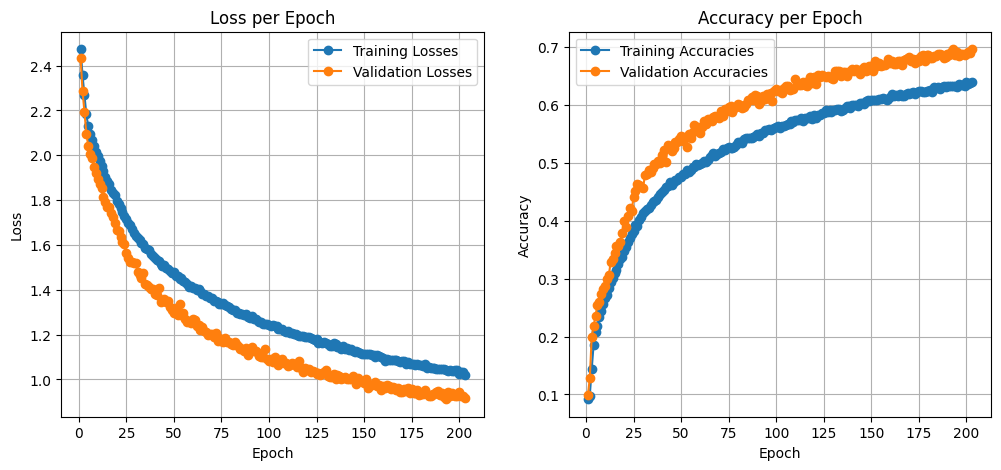

In [210]:
import matplotlib.pyplot as plt
new_epochs = list(range(1, len(training_losses)+1))
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(new_epochs, training_losses, label="Training Losses", marker='o')
plt.plot(new_epochs, validation_losses, label="Validation Losses", marker='o')
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.subplot(1,2,2)
plt.plot(new_epochs, training_accuracies, label="Training Accuracies", marker='o')
plt.plot(new_epochs, validation_accuracies, label="Validation Accuracies", marker='o')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()